# Environment initialization

## Importing Libraries

In [1]:
import os
import sys
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## Loading data

### Methods

1. Loading Pre-trained Model and Features:

- The functions get_duration_predictor(), get_duration_mean(), and get_duration_predictor_features() load the pre-trained model, mean duration values, and model features, respectively. These will be used later to make predictions on the test dataset.
2. Preprocessing the Test Data:

- The get_test_df() function orchestrates the preprocessing of the test data:
- It calls load_test_df() to get the filename of the test dataset.
- Reads the test dataset into a pandas DataFrame.
- Calls rename_cols() to rename columns for consistency.
- Converts the time:timestamp column to a datetime object.
- Calls get_next_events() to generate additional columns for the next event in the sequence.
3. Generating Next Event Features:

- The get_next_events() function sorts the DataFrame by case ID, activity, resource, and timestamp, then shifts columns to get details of the next event (transition, activity, resource, timestamp, and duration). This enables the model to have context about the next events when making predictions.

In [2]:
def get_duration_predictor():
  return  pickle.load(open('duration_predictor.pickle','rb'))

def get_duration_mean():
  return pd.read_csv('duration_predictor_mean.csv')
  

def get_duration_predictor_features():
  return pickle.load(open('duration_predictor_features.pickle','rb'))




def get_test_df():
  csv_filename = load_test_df()
  df = pd.read_csv(csv_filename)
  df = rename_cols(df)
  df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], format="%Y/%m/%d %H:%M:%S")
  df = get_next_events(df)
  return df

def load_test_df():
  csv_filename = 'bpi12_preprocessed_test.csv'
  return csv_filename


def rename_cols(df):
  rename_dict = {'lifecycle:transition_shifted': 'lifecycle:transition_prev',
                  'Activity_shifted':'Activity_prev',
                  'org:resource_shifted': 'org:resource_prev',
                  'time:timestamp_shifted': 'time:timestamp_prev'}
  return df.rename(columns=rename_dict)

def get_next_events(df):
  df = df.sort_values(['Case ID','Activity','org:resource','time:timestamp'])
  df['lifecycle:transition_next'] =  df['lifecycle:transition'].shift(-1)
  df['Activity_next'] = df['Activity'].shift(-1)
  df['org:resource_next'] = df['org:resource'].shift(-1)
  df['time:timestamp_next'] = df['time:timestamp'].shift(-1)
  df['time:timestamp_next'] = pd.to_datetime(df['time:timestamp_next'], format="%Y/%m/%d %H:%M:%S")
  df['Duration(s)_next'] = df['Duration(s)'].shift(-1)
  return df

### Loading data

In [3]:
duration_predictor = get_duration_predictor()
duration_predictor_mean = get_duration_mean()
features = get_duration_predictor_features()
data_test = get_test_df()
base = pd.DataFrame(columns = [col for col in features])
#This line creates an empty DataFrame with columns that match the features expected by the duration predictor model.
base.loc[0] = 0 #This line initializes the first row of the base DataFrame with zeros.


In [4]:
data_test['Duration(s)'].sum()/60/60/24

24.464027777777776

In [5]:
data_test['Duration(s)_next'].sum()/60/60/24

24.464027777777776

In [6]:
base

,workload,W_Assessing the application,W_Calling after sent offers,W_Calling to add missing information to the application,W_Evaluate fraud,W_Filling in information for the application,W_Fixing incoming lead,10138.0,10609.0,10629.0,...,11121.0,11122.0,11169.0,11179.0,11180.0,11181.0,11189.0,11201.0,11203.0,11259.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
LAST_TRAINING_WL = {10138: 0, 10609: 0, 10629: 0, 10809: 0, 10861: 0, 10881: 0, 10889: 0, 
                      10899: 0, 10909: 0, 10910: 1, 10913: 0, 10929: 0, 10932: 0, 10972: 0, 
                      10982: 0, 11000: 1, 11003: 1, 11009: 0, 11049: 0, 11119: 0, 11121: 0, 
                      11122: 0, 11169: 0, 11179: 0, 11180: 0, 11181: 0, 11189: 0, 11201: 0, 
                      11203: 0, 11259: 0}

RESOURCES = [11180,10982,11121,10609,10899,10629,11049,11201,10889,11119,11179,11169,10809,11122,
             11181,11009,11189,10138,10881,10909,10972,11203,10913,11000,10861,11259,10932,10910,
             10929,11003]

In [8]:
data_test.head()

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp,lifecycle:transition_prev,Activity_prev,org:resource_prev,time:timestamp_prev,duration,Duration(s),Workload_count,lifecycle:transition_next,Activity_next,org:resource_next,time:timestamp_next,Duration(s)_next
0,197509,W_Calling after sent offers,2500,03/01/2012 12:52:17,10909.0,COMPLETE,2012-02-11 09:16:04,COMPLETE,W_Calling after sent offers,10909.0,2012-01-26 11:17:51,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,11201.0,2012-02-06 09:15:06,NaN
1,197581,W_Calling after sent offers,10000,03/01/2012 15:29:50,11201.0,COMPLETE,2012-02-06 09:15:06,COMPLETE,W_Calling after sent offers,11201.0,2012-01-30 16:35:50,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,11000.0,2012-02-04 09:15:36,NaN
2,197680,W_Calling after sent offers,4000,03/01/2012 20:07:15,11000.0,COMPLETE,2012-02-04 09:15:36,COMPLETE,W_Calling after sent offers,11000.0,2012-02-02 13:02:08,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",START,W_Calling after sent offers,10909.0,2012-02-11 14:49:25,NaN
3,197701,W_Calling after sent offers,6500,03/01/2012 20:47:09,10909.0,START,2012-02-11 14:49:25,COMPLETE,W_Calling after sent offers,10909.0,2012-01-26 11:24:55,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,10909.0,2012-02-11 14:56:04,399.0
4,197701,W_Calling after sent offers,6500,03/01/2012 20:47:09,10909.0,COMPLETE,2012-02-11 14:56:04,START,W_Calling after sent offers,10909.0,2012-02-11 14:49:25,0 days 00:06:39,399.0,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,11180.0,2012-02-06 09:15:31,NaN


In [9]:
data_test['lifecycle:transition'].value_counts()

COMPLETE    3078
START       3006
Name: lifecycle:transition, dtype: int64

In [10]:
data_test.shape

(6084, 19)

In [11]:
data_test = data_test[((data_test['lifecycle:transition'] == 'START') & (~data_test['Duration(s)_next'].isnull())) | 
                      (data_test['lifecycle:transition'] == 'COMPLETE')]
data_test.shape

(6083, 19)

In [12]:
data_test

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp,lifecycle:transition_prev,Activity_prev,org:resource_prev,time:timestamp_prev,duration,Duration(s),Workload_count,lifecycle:transition_next,Activity_next,org:resource_next,time:timestamp_next,Duration(s)_next
0,197509,W_Calling after sent offers,2500,03/01/2012 12:52:17,10909.0,COMPLETE,2012-02-11 09:16:04,COMPLETE,W_Calling after sent offers,10909.0,2012-01-26 11:17:51,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,11201.0,2012-02-06 09:15:06,NaN
1,197581,W_Calling after sent offers,10000,03/01/2012 15:29:50,11201.0,COMPLETE,2012-02-06 09:15:06,COMPLETE,W_Calling after sent offers,11201.0,2012-01-30 16:35:50,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,11000.0,2012-02-04 09:15:36,NaN
2,197680,W_Calling after sent offers,4000,03/01/2012 20:07:15,11000.0,COMPLETE,2012-02-04 09:15:36,COMPLETE,W_Calling after sent offers,11000.0,2012-02-02 13:02:08,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",START,W_Calling after sent offers,10909.0,2012-02-11 14:49:25,NaN
3,197701,W_Calling after sent offers,6500,03/01/2012 20:47:09,10909.0,START,2012-02-11 14:49:25,COMPLETE,W_Calling after sent offers,10909.0,2012-01-26 11:24:55,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,10909.0,2012-02-11 14:56:04,399.0
4,197701,W_Calling after sent offers,6500,03/01/2012 20:47:09,10909.0,COMPLETE,2012-02-11 14:56:04,START,W_Calling after sent offers,10909.0,2012-02-11 14:49:25,0 days 00:06:39,399.0,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Calling after sent offers,11180.0,2012-02-06 09:15:31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6079,214361,W_Filling in information for the application,5000,29/02/2012 23:11:37,11203.0,COMPLETE,2012-03-01 15:24:17,START,W_Filling in information for the application,11203.0,2012-03-01 15:20:31,0 days 00:03:46,226.0,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",START,W_Fixing incoming lead,11169.0,2012-03-01 09:25:39,NaN
6080,214370,W_Fixing incoming lead,20000,29/02/2012 23:28:55,11169.0,START,2012-03-01 09:25:39,COMPLETE,W_Filling in information for the application,11203.0,2012-03-01 15:24:17,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Fixing incoming lead,11169.0,2012-03-01 09:28:21,162.0
6081,214370,W_Fixing incoming lead,20000,29/02/2012 23:28:55,11169.0,COMPLETE,2012-03-01 09:28:21,START,W_Fixing incoming lead,11169.0,2012-03-01 09:25:39,0 days 00:02:42,162.0,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",START,W_Fixing incoming lead,11169.0,2012-03-01 09:26:46,NaN
6082,214376,W_Fixing incoming lead,15000,29/02/2012 23:51:16,11169.0,START,2012-03-01 09:26:46,COMPLETE,W_Fixing incoming lead,11169.0,2012-03-01 09:28:21,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Fixing incoming lead,11169.0,2012-03-01 09:27:41,55.0


### Loading results

In [13]:
results = [
          ('FQI-none-linear_regression_arrumado-default-0.9', 'Linear Regressor'),
          ('FQI-none-catboost-default-0.9', 'catboost default'),
          ('FQI-none-catboost-100iter-0.9', 'catboost 100'),
          ('FQI-none-catboost-200iter-0.9', 'catboost 200'),
          ('FQI-none-xgboost-default-0.9', 'xg_boost_default'),
          ('FQI-none-xgboost-n_estimators100-0.9','xg_boost_100'),
          ('FQI-none-xgboost-n_estimators50-0.9','xg_boost_50'),
          ('FQI-none-random_forest-default-0.9', 'Random forrest default'),
          ('FQI-none-random_forest-n5-0.9','random_forest_n5'),
          ('FQI-none-random_forest-n50-0.9','randam_forest_n50'),
          ('FQI-none-gradientboosting-default-0.9','gradient boost default'),
          ('FQI-none-gradientboosting-n_estimator50-0.9','gradient boost 50'),
          ('FQI-none-lgbm-defaullt-0.9','LGBM_default'),
          ('FQI-none-cnn-default-0.9','CNN_64_default'),
          ('FQI-none-lstm-default-0.9', 'LSTM_50_default'),
          ('FQI-none-gru-default-0.9', 'GRU_50_default'),
          ]

In [14]:
QS = pd.DataFrame()
STATS = pd.DataFrame()
DELTAS = pd.DataFrame()
CASES_OTIMIZ = pd.DataFrame()

# Simulation to evaluate policy application

## Methods

In [15]:
def process_q(q, alg_name):

  def get_data_pi(n):

    def get_pi():
      pi_filepath = 'C:/Users/LENOVO/Desktop/phase3/results/pis/'
      pi_filename = '%s-n_%s.csv'%(alg_name,str(n))
      if os.path.isfile(pi_filepath+pi_filename):
        return pd.read_csv(open(pi_filepath+pi_filename, 'r'))
      pi = get_pii(q, n)
      save_pi(pi)
      return pi

    def save_pi(pi):
      with open('C:/Users/LENOVO/Desktop/phase3/results/pis/%s'%filename, 'w') as f:
        pi.to_csv(f, index=False)

    def save_data_pi():
      with open('C:/Users/LENOVO/Desktop/phase3/results/pi_applied_data/%s'%filename, 'w') as f:
        data_pi[['Case ID', 'Activity', 'Duration(s)_next','pi_action','pred_duration','pi_action_dur_source', 'Workload', 'time:timestamp']].to_csv(f, index=False)
    
    filepath = 'C:/Users/LENOVO/Desktop/phase3/results/pi_applied_data/'
    filename = '%s-n_%s.csv'%(alg_name,str(n))
    if os.path.isfile(filepath+filename):
      return pd.read_csv(open(filepath+filename, 'r'))
    
    pi = get_pi()
    data_pi = apply_pi(pi)
    save_data_pi()
  
    return data_pi

  global QS, DELTAS, STATS, CASES_OTIMIZ

  d_melted_n = q.melt(id_vars=['case','state','action','cost', 'next_state'])
  d_melted_n = d_melted_n.rename(columns={'variable':'N', 'value':'Q'})
  d_melted_n['N'] = d_melted_n['N'].astype(int)
  d_melted_n['Q'] = d_melted_n['Q']/3600 #em horas
  d_melted_n['Modelo'] = alg_name
  QS = pd.concat([QS, d_melted_n])

  diffs = {'N':[], 'Delta':[]}
  q_stats = {'Total(d)': [], 'Otimizados (%)': [], 'N':[], 'Modelo': [], 
             '#Original_dur':[], '#Dur_model':[], '#Dur_avg_wl':[], '#Dur_avg_act':[], '#Events Otimiz':[]}
  data_test_pi = None
  last_n = d_melted_n.N.max()
  for n in range(1, last_n+1):
    print(n)
    diffs['N'].append(n)
    diffs['Delta'].append(abs(q[str(n)]-q[str(n-1)]).sum()/3600)

    data_test_pi = get_data_pi(n)

    cases_otimiz = pd.DataFrame(data_test_pi.groupby('Case ID')['Duration(s)_next'].sum().reset_index())
    cases_otimiz['Pi'] = data_test_pi.groupby('Case ID')['pred_duration'].sum().reset_index()['pred_duration']
    cases_otimiz['Otimizacao'] = cases_otimiz['Pi']-cases_otimiz['Duration(s)_next']

    q_stats['Total(d)'].append(data_test_pi.pred_duration.sum()/3600/24),
    q_stats['Otimizados (%)'].append((cases_otimiz['Otimizacao'] < 0).sum()/len(cases_otimiz['Case ID'].unique()))
    q_stats['#Original_dur'].append(data_test_pi[data_test_pi['pi_action_dur_source'] == 'original'].shape[0])
    q_stats['#Dur_model'].append(data_test_pi[data_test_pi['pi_action_dur_source'] == 'ml_model'].shape[0])
    q_stats['#Dur_avg_wl'].append(data_test_pi[data_test_pi['pi_action_dur_source']=='avg_wl'].shape[0])
    q_stats['#Dur_avg_act'].append(data_test_pi[data_test_pi['pi_action_dur_source']=='avg_act'].shape[0])
    data_test_pi['pi-original_duration'] = data_test_pi['pred_duration'] - data_test_pi['Duration(s)_next']
    q_stats['#Events Otimiz'].append(data_test_pi[data_test_pi['pi-original_duration'] < 0].shape[0]/data_test_pi.shape[0])
    q_stats['N'].append(n)
    q_stats['Modelo'].append(alg_name)
  
  

  STATS = pd.concat([STATS, pd.DataFrame(q_stats)])
  
  diffs = pd.DataFrame(diffs)
  diffs['Modelo'] = alg_name
  DELTAS = pd.concat([DELTAS, diffs])
  
  cases_otimiz['Modelo'] = alg_name
  cases_otimiz.rename(columns={'Duration(s)_next':'Custo original'})
  CASES_OTIMIZ = pd.concat([CASES_OTIMIZ, cases_otimiz])

In [16]:
def get_pii(states_set, n):
  aux = pd.DataFrame(states_set.groupby(['state','action']).apply(lambda x: x[str(n)].mean())).reset_index()
  return aux.loc[aux.groupby(['state'])[0].idxmin()]

def apply_pi(pi):
  def inicialize_workload_count():
    WORKLOAD_COUNT = pd.DataFrame(columns=RESOURCES)
    WORKLOAD_COUNT.loc[0] = 0
    #partir do Workload_count final do treinamento
    wc_final_train = LAST_TRAINING_WL
    for r,count in wc_final_train.items():
      WORKLOAD_COUNT[r].loc[0] = count
    return WORKLOAD_COUNT

  def process_event(event):

    def set_event_wl():
      wl = get_wl(WORKLOAD_COUNT)
      event['Workload'] = get_wl_dict(wl)
      return wl


    def get_wl(wl_count):
      activities_being_exec = wl_count.T.sum().loc[0]
      AVG_R = (activities_being_exec/len(wl_count.columns)) 

      def get_scale_int(x):
        if x[0] < 1:
          x[0] = 0#'FREE'
          return x
        if x[0] <= AVG_R:
          x[0] = 1#'LOW'
          return x
        x[0] = 2#'HIGH'
        return x
      
      wl = wl_count.copy().T
      wl = wl.apply(get_scale_int, axis=1)
      return wl.T


    def get_wl_dict(wl):
      return wl.to_dict('records')[0]


    def get_original_duration():
      original_duration = None
      if (event['lifecycle:transition_next'] == 'COMPLETE' and 
          event['Activity_next'] == event['Activity'] and
          event['org:resource_next'] == event['org:resource']):
        # verified that the dilemma of having two activity instances started for the same case (and executed by the same resource), 
        #  described in Process Mining book (by W. van der Aalst), p.132, does not happen in this log
        original_duration = event['Duration(s)_next'] 
      return original_duration


    def set_action_and_duration(wl):
      s = event['Activity'] + '-' + get_wl_str(event['Workload'])
      a_pi, duration, source = get_pi_action_and_duration(s, event['org:resource'], original_duration, 
                                                  event['Activity'], wl)
      event['pi_action'] = a_pi
      event['pred_duration'] = duration
      event['pi_action_dur_source'] = source


    def get_wl_str(wl):
      return json.dumps(wl).replace('"','').replace(': 0',": 'FREE'").replace(': 1',": 'LOW'").replace(': 2',": 'HIGH'")


    def get_pi_action_and_duration(state, original_action, original_duration, activity, wl):
      selection = pi[pi['state'] == state].action
      if selection.shape[0]>0:
        a_pi = int(selection.iloc[0])
        WORKLOAD_COUNT[a_pi] = WORKLOAD_COUNT[a_pi] + 1
        duration, source = predict_duration(a_pi, activity, wl)
        return a_pi, duration, source
      WORKLOAD_COUNT[int(original_action)] = WORKLOAD_COUNT[int(original_action)] + 1
      return original_action, original_duration, 'original'


    def predict_duration(action, activity, wl):
      x_predictor = base.copy() #indicar a atividade e o recurso 
      x_predictor.loc[float(action)] = 1
      x_predictor.loc[activity] = 1
      x_predictor.loc['workload'] = wl[action].iloc[0]
      #return max(0,duration_predictor.predict(x_predictor)[0])
      pred = duration_predictor.predict(x_predictor)[0]
      if pred > 0:
        return pred, 'ml_model'
      select_mean = duration_predictor_mean[(duration_predictor_mean['org:resource']==action) &
                            (duration_predictor_mean['Activity']==activity) &
                            (duration_predictor_mean['Workload-esp_resource']==wl[action].iloc[0])]
      if select_mean.shape[0]>0:
        return select_mean['mean'].iloc[0], 'avg_wl'
      return duration_predictor_mean[(duration_predictor_mean['org:resource']==action) &
                              (duration_predictor_mean['Activity']==activity)].mean.mean(), 'avg_act'


    def create_sint_complete_event():
      global DATA2PROCESS
      end_event = event.copy()
      event_complete_ts = event['time:timestamp'] + pd.to_timedelta(event['pred_duration'], unit = 'seconds')
      end_event['time:timestamp'] = event_complete_ts
      end_event['lifecycle:transition'] = 'SINT_COMPLETE' 
      DATA2PROCESS = DATA2PROCESS.append(end_event)

      return event_complete_ts


    def update_case_events_ts(event_complete_ts, original_duration):
      case_mask = (DATA2PROCESS['Case ID'] == event['Case ID'])
      ts_mask = (DATA2PROCESS['time:timestamp'] > event_complete_ts)

      durat_diff = 0

      durat_diff = original_duration - event['pred_duration']
      if durat_diff != 0:
        DATA2PROCESS.loc[case_mask & ts_mask, 'time:timestamp'] = DATA2PROCESS.loc[case_mask & ts_mask, 'time:timestamp'] - pd.to_timedelta(durat_diff, unit = 'seconds')

    # MAIN OF APPLY_PI METHOD
    if event['lifecycle:transition'] == 'START':
      wl = set_event_wl()
      original_duration = get_original_duration()
      set_action_and_duration(wl) #from pi
      event_complete_ts = create_sint_complete_event()
      update_case_events_ts(event_complete_ts, original_duration)

    if event['lifecycle:transition'] == 'SINT_COMPLETE':
      WORKLOAD_COUNT[int(event['pi_action'])] = WORKLOAD_COUNT[int(event['pi_action'])] - 1
    
    return event

  #MAIN OF APPLY_PI METHOD
  global DATA2PROCESS
  WORKLOAD_COUNT = inicialize_workload_count()
  DATA2PROCESS = data_test.sort_values('time:timestamp').copy()
  PROCESSED = pd.DataFrame()

  while DATA2PROCESS.shape[0]>1:
    PROCESSED = PROCESSED.append(process_event(DATA2PROCESS.iloc[0]))
    DATA2PROCESS = DATA2PROCESS.iloc[1:].sort_values('time:timestamp')

  return PROCESSED[PROCESSED['lifecycle:transition']!= 'SINT_COMPLETE']

## Apply policy and collect statistics

In [17]:
for filename, alg in results:
    print(alg)
    # Load the CSV file
    q = pd.read_csv(f'C:/Users/LENOVO/Desktop/phase3/results/{filename}.csv')
    # Process the data
    process_q(q, alg)

Linear Regressor
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
catboost default
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
catboost 100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
catboost 200
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
xg_boost_default
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
xg_boost_100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
xg_boost_50
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
Random forrest default
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
random_forest_n5
1
2
3
4
5
6
7
8
9
10
11
12
randam_forest_n50
1
2
3
4
5
6
7
8
9
10
11
12
13
gradient boost default
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
gradient boost 50
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
LGBM_default
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
CNN_64

## Gráficos



In [18]:
STATS.head()

,Total(d),Otimizados (%),N,Modelo,#Original_dur,#Dur_model,#Dur_avg_wl,#Dur_avg_act,#Events Otimiz
0,21.733502,0.179487,1,Linear Regressor,1799,0,1206,0,0.054743
1,19.208203,0.179487,2,Linear Regressor,1740,0,1265,0,0.059346
2,19.152760,0.185315,3,Linear Regressor,1768,0,1237,0,0.056551
3,19.152760,0.185315,4,Linear Regressor,1768,0,1237,0,0.056551
4,18.321070,0.213287,5,Linear Regressor,1721,0,1284,0,0.063291


In [19]:
DELTAS.Modelo.unique()

array(['Linear Regressor', 'catboost default', 'catboost 100',
       'catboost 200', 'xg_boost_default', 'xg_boost_100', 'xg_boost_50',
       'Random forrest default', 'random_forest_n5', 'randam_forest_n50',
       'gradient boost default', 'gradient boost 50', 'LGBM_default',
       'CNN_64_default', 'LSTM_50_default', 'GRU_50_default'],
      dtype=object)

In [52]:
deep_models = ['CNN_64_default', 'LSTM_50_default', 'GRU_50_default']
ml_models = ['Linear Regressor', 'catboost default', 'catboost 100',  'catboost 200', 'xg_boost_default', 'xg_boost_100', 'xg_boost_50'
            ,'gradient boost default', 'gradient boost 50', 'LGBM_default']

In [53]:
graph_delta = px.line(DELTAS[DELTAS.Modelo.isin(deep_models)].rename(columns={'Delta':'∆', 'N':'Iteration'}), 
                      x = 'Iteration', y = '∆', color = 'Modelo',
                      template = 'plotly_white', color_discrete_sequence = px.colors.qualitative.Light24)
graph_delta.show()

In [54]:
graph_delta_n = px.line(DELTAS[DELTAS.Modelo.isin(ml_models)].rename(columns={'Delta':'∆', 'N':'Iteration'}), 
                      x = 'Iteration', y = '∆', color = 'Modelo',
                      template = 'plotly_white', color_discrete_sequence = px.colors.qualitative.Light24)
graph_delta_n.show()

The above graph shows that how difference decreases as iteration increases in policy

In [89]:
graph_q = px.line(QS[QS.Modelo.isin(deep_models)].groupby(['N','Modelo']).sum().reset_index(), 
                  x='N', y = 'Q', color = 'Modelo',
                  template = 'plotly_white')


graph_total = px.line(STATS[STATS.Modelo.isin(deep_models)].sort_values(by=['Modelo','N']), x='N', y = 'Total(d)', color = 'Modelo',
                  template = 'plotly_white')

graph_improv = px.line(STATS[STATS.Modelo.isin(deep_models)].sort_values(by=['Modelo','N']), x='N', y = 'Otimizados (%)', color = 'Modelo',
                  template = 'plotly_white')
graph_pi = px.line(STATS[STATS.Modelo.isin(deep_models)].sort_values(by=['Modelo','N']), x='N', y = '#Dur_avg_wl', color = 'Modelo',
                  template = 'plotly_white')

graph_q.show()
graph_total.show()
graph_improv.show()
graph_pi.show()

In [88]:
graph_q = px.line(QS[QS.Modelo.isin(ml_models)].groupby(['N','Modelo']).sum().reset_index(), 
                  x='N', y = 'Q', color = 'Modelo',
                  template = 'plotly_white')


graph_total = px.line(STATS[STATS.Modelo.isin(ml_models)].sort_values(by=['Modelo','N']), x='N', y = 'Total(d)', color = 'Modelo',
                  template = 'plotly_white')

graph_improv = px.line(STATS[STATS.Modelo.isin(ml_models)].sort_values(by=['Modelo','N']), x='N', y = 'Otimizados (%)', color = 'Modelo',
                  template = 'plotly_white')
graph_pi = px.line(STATS[STATS.Modelo.isin(ml_models)].sort_values(by=['Modelo','N']), x='N', y = '#Dur_avg_wl', color = 'Modelo',
                  template = 'plotly_white')

graph_q.show()
graph_total.show()
graph_improv.show()
graph_pi.show()

## Indexes

In [57]:
pd.set_option('display.max_columns', None)


extract and compile the last (maximum) iteration results for each model from the STATS DataFrame. Let's break down the steps in detail.

In [58]:
max = STATS.groupby('Modelo').N.max()
res = pd.DataFrame()
for alg in list(max.index):
  res = pd.concat([res, STATS[(STATS['Modelo'] == alg) & (STATS['N'] == max[alg])]])
res

,Total(d),Otimizados (%),N,Modelo,#Original_dur,#Dur_model,#Dur_avg_wl,#Dur_avg_act,#Events Otimiz
98,15.881219,0.350816,99,CNN_64_default,1499,0,1506,0,0.104554
98,23.919774,0.198135,99,GRU_50_default,1774,0,1231,0,0.065921
24,21.528971,0.215618,25,LGBM_default,1630,0,1375,0,0.077265
98,29.166157,0.121212,99,LSTM_50_default,2011,0,994,0,0.047509
30,15.881219,0.350816,31,Linear Regressor,1499,0,1506,0,0.104554
16,19.693183,0.214452,17,Random forrest default,1740,0,1265,0,0.063127
25,15.815848,0.297203,26,catboost 100,1639,0,1366,0,0.081210
23,19.427596,0.354312,24,catboost 200,1557,0,1448,0,0.102745
22,15.187745,0.347319,23,catboost default,1528,0,1477,0,0.102581
25,18.722334,0.264569,26,gradient boost 50,1611,0,1394,0,0.082854


In [59]:
print(max)
print(STATS.head())

Modelo
CNN_64_default            99
GRU_50_default            99
LGBM_default              25
LSTM_50_default           99
Linear Regressor          31
Random forrest default    17
catboost 100              26
catboost 200              24
catboost default          23
gradient boost 50         26
gradient boost default    26
randam_forest_n50         13
random_forest_n5          12
xg_boost_100              26
xg_boost_50               24
xg_boost_default          26
Name: N, dtype: int64
    Total(d)  Otimizados (%)  N            Modelo  #Original_dur  #Dur_model  \
0  21.733502        0.179487  1  Linear Regressor           1799           0   
1  19.208203        0.179487  2  Linear Regressor           1740           0   
2  19.152760        0.185315  3  Linear Regressor           1768           0   
3  19.152760        0.185315  4  Linear Regressor           1768           0   
4  18.321070        0.213287  5  Linear Regressor           1721           0   

   #Dur_avg_wl  #Dur_avg_a

In [60]:
res['Pi applied'] = res['#Dur_avg_wl'] / 3005

In [61]:
res[['Modelo', 'N', 'Total(d)', 'Pi applied','#Events Otimiz', 'Otimizados (%)']].sort_values('Modelo', ascending=False)

,Modelo,N,Total(d),Pi applied,#Events Otimiz,Otimizados (%)
25,xg_boost_default,26,19.131252,0.462562,0.081374,0.275058
23,xg_boost_50,24,18.131398,0.463228,0.082196,0.271562
25,xg_boost_100,26,19.131252,0.462562,0.081374,0.275058
11,random_forest_n5,12,25.710484,0.382363,0.061976,0.164336
12,randam_forest_n50,13,19.692344,0.420965,0.063127,0.214452
25,gradient boost default,26,18.917458,0.454908,0.080717,0.266900
25,gradient boost 50,26,18.722334,0.463894,0.082854,0.264569
22,catboost default,23,15.187745,0.491514,0.102581,0.347319
23,catboost 200,24,19.427596,0.481864,0.102745,0.354312
25,catboost 100,26,15.815848,0.454576,0.081210,0.297203


In [62]:
CASES_OTIMIZ['Duration(s)_next'] = CASES_OTIMIZ['Duration(s)_next']/2 
CASES_OTIMIZ.Otimizacao = CASES_OTIMIZ['Pi'] - CASES_OTIMIZ['Duration(s)_next']
CASES_OTIMIZ[CASES_OTIMIZ.Otimizacao < 0].groupby(['Case ID','Modelo']).sum()

Duration(s)_next           Pi  Otimizacao
Case ID  Modelo                                                           
197701.0 GRU_50_default                     199.5   172.473333  -27.026667
199462.0 random_forest_n5                  1298.5  1291.192053   -7.307947
199633.0 gradient boost 50                  404.0   177.469697 -226.530303
199860.0 xg_boost_50                       2617.5  2614.747609   -2.752391
200085.0 LSTM_50_default                    350.5   169.672414 -180.827586
...                                           ...          ...         ...
214319.0 gradient boost default             504.5   265.460227 -239.039773
         xg_boost_100                       504.5   265.460227 -239.039773
         xg_boost_default                   504.5   265.460227 -239.039773
214322.0 random_forest_n5                   189.0    77.826087 -111.173913
214334.0 random_forest_n5                   132.0    99.132353  -32.867647

[976 rows x 3 columns]

In [63]:
CASES_OTIMIZ[CASES_OTIMIZ.Otimizacao == 0].groupby(['Case ID','Modelo']).sum()

Duration(s)_next   Pi  Otimizacao
Case ID  Modelo                                              
197509.0 CNN_64_default                  0.0  0.0         0.0
         GRU_50_default                  0.0  0.0         0.0
         LGBM_default                    0.0  0.0         0.0
         LSTM_50_default                 0.0  0.0         0.0
         Linear Regressor                0.0  0.0         0.0
...                                      ...  ...         ...
204808.0 randam_forest_n50               0.0  0.0         0.0
         random_forest_n5                0.0  0.0         0.0
         xg_boost_100                    0.0  0.0         0.0
         xg_boost_50                     0.0  0.0         0.0
         xg_boost_default                0.0  0.0         0.0

[256 rows x 3 columns]

In [64]:
CASES_OTIMIZ[CASES_OTIMIZ.Otimizacao > 0].groupby(['Case ID','Modelo']).sum()

Duration(s)_next     Pi  Otimizacao
Case ID  Modelo                                                     
197701.0 CNN_64_default                     199.5  399.0       199.5
         LGBM_default                       199.5  792.6       593.1
         LSTM_50_default                    199.5  399.0       199.5
         Linear Regressor                   199.5  399.0       199.5
         Random forrest default             199.5  399.0       199.5
...                                           ...    ...         ...
214376.0 randam_forest_n50                   27.5   55.0        27.5
         random_forest_n5                    27.5   55.0        27.5
         xg_boost_100                        27.5   55.0        27.5
         xg_boost_50                         27.5   55.0        27.5
         xg_boost_default                    27.5   55.0        27.5

[12496 rows x 3 columns]

# Check the distribution of resources in the states in each policy

In [68]:
PIS_PATH = 'C:/Users/LENOVO/Desktop/phase3/results/pis/'
filenames = [filename for filename in os.listdir(PIS_PATH)]
filenames = sorted(filenames)

In [69]:
APPLIED_DATA_PATH = 'C:/Users/LENOVO/Desktop/phase3/results/pi_applied_data/'
filenames = [filename for filename in os.listdir(PIS_PATH)]
filenames = sorted(filenames)
pis_df = pd.DataFrame({'filename':  filenames})
filenames = {filename.split('-n')[0]: filename for filename in filenames}

import ast
def check_workloads(x,n):
  if x['Workload'] is not np.nan:
    wl = ast.literal_eval(x['Workload'])
    x['>%s?'%str(n)] = pd.Series([wl[resource] > n for resource in wl]).sum()
  return x

res_in_pis = pd.DataFrame()
for model in filenames:
  filename = filenames[model]
  pi = pd.read_csv(PIS_PATH+filename)
  pi['activity'] = pi.state.apply(lambda x: x.split('-')[0])
  applied_data = pd.read_csv(APPLIED_DATA_PATH+filename)
  for n in [1,2]:
    applied_data = applied_data.apply(lambda x: check_workloads(x,n), axis=1)
    count = pd.DataFrame(pi.groupby('activity').action.nunique()).T.reset_index(drop=True)
    count['Modelo'] = model
    #count['Overload'] = pd.DataFrame(applied_data['>%s?'%str(n)].value_counts()).to_dict()['>%s?'%str(n)]
    res_in_pis = pd.concat([count, res_in_pis])

In [70]:
res_in_pis

activity,W_Assessing the application,W_Calling after sent offers,W_Calling to add missing information to the application,W_Evaluate fraud,W_Filling in information for the application,W_Fixing incoming lead,Modelo
0,11,29,27,1,28,24,xg_boost_default
0,11,29,27,1,28,24,xg_boost_default
0,10,28,27,1,27,24,xg_boost_50
0,10,28,27,1,27,24,xg_boost_50
0,11,29,27,1,28,24,xg_boost_100
0,11,29,27,1,28,24,xg_boost_100
0,15,28,27,1,27,24,random_forest_n5
0,15,28,27,1,27,24,random_forest_n5
0,12,28,27,1,27,25,randam_forest_n50
0,12,28,27,1,27,25,randam_forest_n50


# Check resource occupancy after applying the policy

## Resource occupancy graph

Make the same resource occupancy graph only during the test set events after applying the policy

In [71]:
APPLIED_DATA_PATH = 'C:/Users/LENOVO/Desktop/phase3/results/pi_applied_data/'
applied_data_filename = 'catboost default-n_15.csv'
applied_data = pd.read_csv(APPLIED_DATA_PATH + applied_data_filename)
applied_data['time:timestamp'] = pd.to_datetime(applied_data['time:timestamp'], 
                                                format="%Y/%m/%d %H:%M:%S")

In [72]:
applied_data.head()

,Case ID,Activity,Duration(s)_next,pi_action,pred_duration,pi_action_dur_source,Workload,time:timestamp
0,202185.0,W_Calling to add missing information to the ap...,133.0,10629.0,272.461538,avg_wl,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899...",2012-02-03 16:40:30.000000000
1,202185.0,W_Calling to add missing information to the ap...,NaN,NaN,NaN,NaN,NaN,2012-02-03 16:42:43.000000000
2,206053.0,W_Filling in information for the application,548.0,10861.0,248.460227,avg_wl,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899...",2012-02-03 16:47:24.000000000
3,206053.0,W_Filling in information for the application,NaN,NaN,NaN,NaN,NaN,2012-02-03 16:51:32.460227273
4,202947.0,W_Calling to add missing information to the ap...,1028.0,10629.0,272.461538,avg_wl,"{11180: 0, 10982: 0, 11121: 0, 10609: 0, 10899...",2012-02-03 16:51:59.000000000


In [73]:
from ast import literal_eval

#in vector representation
def def_workload_status(x):
  def get_r_workload(resource):
    if x['Workload'][resource] == 0:
      return 'FREE'
    elif x['Workload'][resource] == 1: 
      return 'LOW'
    return 'HIGH' 
  x['Workload'] = {resource: get_r_workload(resource) for resource in x['Workload']}
  return x
applied_data = applied_data.dropna()
applied_data['Workload'] = applied_data['Workload'].apply(lambda x: literal_eval(x))
applied_data = applied_data.apply(lambda x: def_workload_status(x), axis=1)

In [74]:
def get_res_wl(x):
  x['Resource Workload'] = x['Workload'][int(x['pi_action'])]
  return x
applied_data = applied_data.apply(get_res_wl, axis=1)

In [75]:
applied_data['Resource Workload'].value_counts()

FREE    2632
HIGH     373
Name: Resource Workload, dtype: int64

In [76]:
grouped = pd.DataFrame(applied_data.reset_index()
                             .groupby(['pi_action','Resource Workload'])['index']
                             .count())
grouped = (grouped.reset_index()
                 .rename(columns = {'index':'Count'})
                 .sort_values(['Resource Workload','Count']))

total_per_resource_test = grouped.groupby('pi_action').sum().rename(columns={'Count':'Sum'})
grouped_relative = total_per_resource_test.join(grouped.set_index('pi_action')).reset_index()
grouped_relative['Count relative'] = grouped_relative.apply(lambda x: x.Count/x.Sum, axis=1)

In [77]:
grouped

,pi_action,Resource Workload,Count
20,10929.0,FREE,3
12,10889.0,FREE,14
6,10809.0,FREE,27
42,11180.0,FREE,31
46,11201.0,FREE,36
21,10932.0,FREE,38
31,11049.0,FREE,38
36,11122.0,FREE,41
18,10913.0,FREE,43
35,11121.0,FREE,43


In [78]:
fig = px.bar(grouped.sort_values(by = ['pi_action','Resource Workload'], ascending =[True,False]).round(2), x = 'pi_action', y = 'Count', 
             color = 'Resource Workload', text = 'Count', template = 'plotly_white', barmode='group',
             category_orders={'pi_action': grouped_relative.sort_values('pi_action').pi_action})
fig.update_xaxes(type='category')
fig

In [79]:
fig = px.bar(grouped_relative.sort_values('pi_action').round(2), x = 'pi_action', y = 'Count relative', 
             color = 'Resource Workload', text = 'Count relative', template = 'plotly_white', height = 400, 
             category_orders={'pi_action': grouped_relative.sort_values('pi_action').pi_action})
fig.update_xaxes(type='category', tickangle=45)

fig

In [80]:
px.box(applied_data, y = 'pred_duration', color = 'Resource Workload', width = 400, height = 600, template = 'plotly_white')

## Resource count

In [81]:
pd.DataFrame(applied_data.groupby('Activity')['pi_action'].value_counts())

pi_action
Activity                    pi_action           
W_Assessing the application 10629.0          253
                            10138.0           76
                            10609.0           71
                            10972.0           58
                            10809.0           21
...                                          ...
W_Fixing incoming lead      11121.0            4
                            10609.0            1
                            10929.0            1
                            11180.0            1
                            11181.0            1

[107 rows x 1 columns]

In [82]:
applied_data.pi_action.value_counts()

10629.0    461
11181.0    395
10861.0    316
10881.0    274
11179.0    159
10982.0    128
11203.0    127
11169.0     93
10609.0     92
10899.0     91
11009.0     84
11119.0     82
10138.0     82
10972.0     66
10909.0     63
11259.0     55
11000.0     50
11003.0     49
10913.0     44
11201.0     43
11121.0     43
11122.0     42
11049.0     42
10932.0     39
11180.0     34
10809.0     31
10889.0     17
10929.0      3
Name: pi_action, dtype: int64

# Create log from simulation result


Pass the result of applying the policy to the test suite to log format

### Original test set

In [83]:
from IPython.display import FileLink
filter_rows = (data_test['lifecycle:transition']=='START')&(~data_test['Duration(s)_next'].isnull())
filter_cols = ['Case ID', 'Activity', 'time:timestamp', 'org:resource', 'Duration(s)_next']
data_test_select = data_test[filter_rows][filter_cols]
data_test_select['Duration(s)_next'] = data_test_select['Duration(s)_next'].apply(lambda x: pd.Timedelta(x, unit='seconds')) 
data_test_select['end_ts'] = data_test_select['time:timestamp'] + data_test_select['Duration(s)_next']

data_test_select = data_test_select.rename(columns={#'time:timestamp':'original_timestamp',
                                                    'org:resource': 'Resource',
                                                    'Duration(s)_next':'Duration(s)'})
data_test_select.to_csv('data_test-log_format.csv')
FileLink('data_test-log_format.csv')

C:\Users\LENOVO\Desktop\phase3\data_test-log_format.csv

In [84]:
data_test_select[data_test_select['Case ID'] == 206639]

,Case ID,Activity,time:timestamp,Resource,Duration(s),end_ts
1927,206639,W_Filling in information for the application,2012-02-06 18:33:55,11181.0,0 days 00:25:17,2012-02-06 18:59:12
1929,206639,W_Fixing incoming lead,2012-02-06 09:32:53,11179.0,0 days 00:02:05,2012-02-06 09:34:58


### Mock Test Suite

In [85]:
ap_log = applied_data.dropna()
ap_log['Case ID'] = ap_log['Case ID'].astype(int)
ap_log['Duration'] = ap_log['pred_duration'].apply(lambda x: pd.Timedelta(x, unit='seconds')) 
ap_log['timestamp_end'] = ap_log['time:timestamp'] + ap_log['Duration']
ap_log = ap_log.rename(columns={'time:timestamp':'timestamp_start',
                                'pi_action':'Resource'})
ap_log = ap_log[['Case ID','Activity','Resource','Resource Workload','Duration','timestamp_start','timestamp_end']]

In [86]:
logfilename = applied_data_filename.replace('.csv','-logformat.csv')
ap_log.to_csv(logfilename)
FileLink(logfilename)

C:\Users\LENOVO\Desktop\phase3\catboost default-n_15-logformat.csv

In [107]:
print(applied_data['pred_duration'].max())
data_test_select['Duration(s)'].max()

69594.0


221140.0

In [106]:
data_test_select['Duration(s)'] = pd.to_timedelta(data_test_select['Duration(s)']).dt.total_seconds()

In [99]:
import matplotlib.pyplot as plt

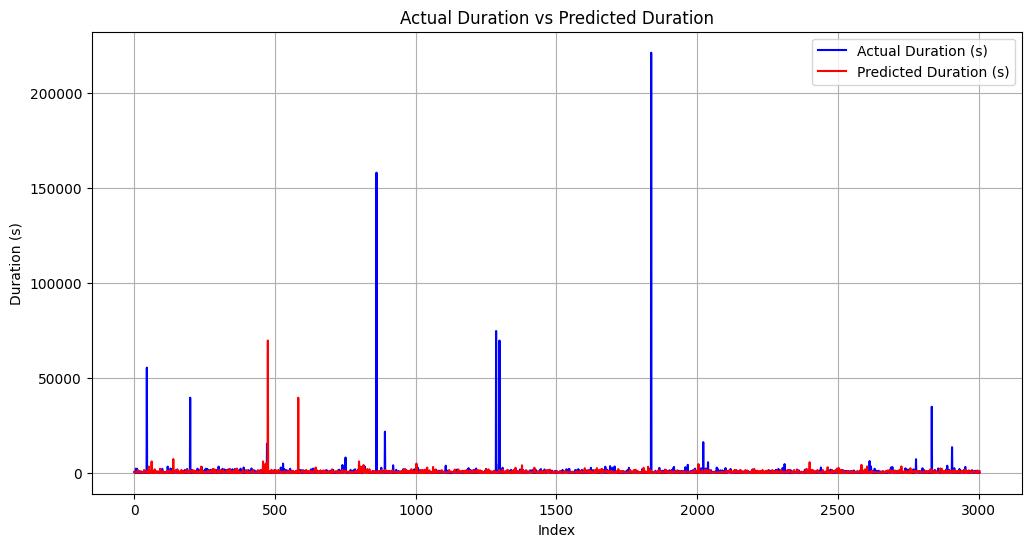

In [108]:
duration_actual = data_test_select['Duration(s)']
predicted_duration = applied_data['pred_duration']

# Plotting the data
plt.figure(figsize=(12, 6))

plt.plot(duration_actual.values, label='Actual Duration (s)', color='b')
plt.plot(predicted_duration.values, label='Predicted Duration (s)', color='r')

plt.xlabel('Index')
plt.ylabel('Duration (s)')
plt.title('Actual Duration vs Predicted Duration')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

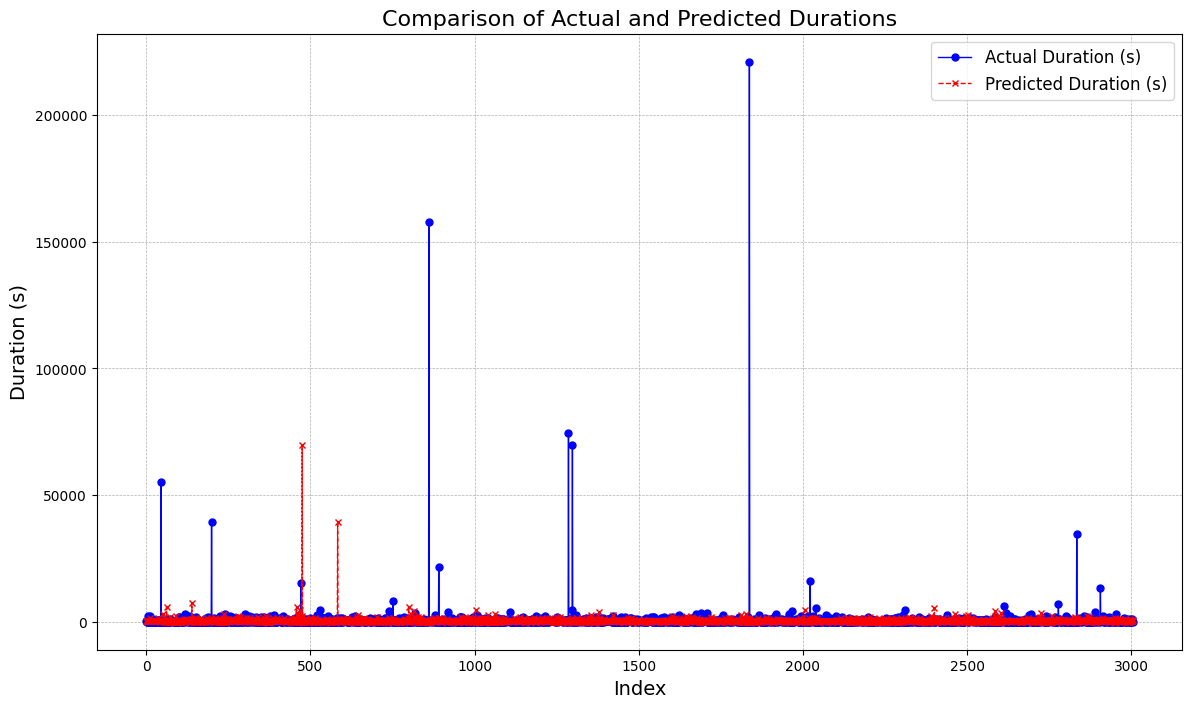

In [109]:
import matplotlib.pyplot as plt

# Assuming data_test_select and applied_data are already defined and contain the relevant columns
duration_actual = data_test_select['Duration(s)']
predicted_duration = applied_data['pred_duration']

# Plotting the data
plt.figure(figsize=(14, 8))

# Plot actual duration
plt.plot(duration_actual.values, label='Actual Duration (s)', color='b', marker='o', linestyle='-', linewidth=1, markersize=5)

# Plot predicted duration
plt.plot(predicted_duration.values, label='Predicted Duration (s)', color='r', marker='x', linestyle='--', linewidth=1, markersize=5)

# Adding labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Duration (s)', fontsize=14)
plt.title('Comparison of Actual and Predicted Durations', fontsize=16)

# Adding legend
plt.legend(loc='best', fontsize=12)

# Adding grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5)

# Display the plot
plt.show()


# Check if the timestamp has been properly changed

When the duration of an activity is changed, the start timestamp of all next activities in the case should be changed

In [110]:
applied_data[applied_data['Case ID']==198310].sort_values('time:timestamp')

,Case ID,Activity,Duration(s)_next,pi_action,pred_duration,pi_action_dur_source,Workload,time:timestamp,Resource Workload
553,198310.0,W_Assessing the application,18.0,10629.0,827.192053,avg_wl,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",2012-02-07 14:02:55.000000000,FREE
688,198310.0,W_Assessing the application,45.0,10609.0,45.000000,original,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",2012-02-08 09:29:51.192052980,FREE
1125,198310.0,W_Assessing the application,15.0,10629.0,827.192053,avg_wl,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",2012-02-09 16:23:30.192052980,FREE
2569,198310.0,W_Assessing the application,374.0,10138.0,374.000000,original,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",2012-02-15 16:49:22.384105960,FREE
2630,198310.0,W_Assessing the application,113.0,10629.0,827.192053,avg_wl,"{11180: 'FREE', 10982: 'FREE', 11121: 'FREE', ...",2012-02-16 08:41:14.384105960,FREE


In [111]:
data_test[(data_test['Case ID']==198310)&(data_test['lifecycle:transition']=='START')].sort_values('time:timestamp')

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp,lifecycle:transition_prev,Activity_prev,org:resource_prev,time:timestamp_prev,duration,Duration(s),Workload_count,lifecycle:transition_next,Activity_next,org:resource_next,time:timestamp_next,Duration(s)_next
16,198310,W_Assessing the application,25000,05/01/2012 14:24:08,11259.0,START,2012-02-07 14:02:55,COMPLETE,W_Assessing the application,10809.0,2012-01-24 14:40:21,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Assessing the application,11259.0,2012-02-07 14:03:13,18.0
9,198310,W_Assessing the application,25000,05/01/2012 14:24:08,10609.0,START,2012-02-08 09:16:22,COMPLETE,W_Assessing the application,10138.0,2012-02-15 16:28:35,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Assessing the application,10609.0,2012-02-08 09:17:07,45.0
11,198310,W_Assessing the application,25000,05/01/2012 14:24:08,10609.0,START,2012-02-09 16:10:01,COMPLETE,W_Assessing the application,10609.0,2012-02-08 09:17:07,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Assessing the application,10609.0,2012-02-09 16:10:16,15.0
7,198310,W_Assessing the application,25000,05/01/2012 14:24:08,10138.0,START,2012-02-15 16:22:21,COMPLETE,W_Fixing incoming lead,11003.0,2012-01-05 14:00:02,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Assessing the application,10138.0,2012-02-15 16:28:35,374.0
13,198310,W_Assessing the application,25000,05/01/2012 14:24:08,10629.0,START,2012-02-16 08:14:13,COMPLETE,W_Assessing the application,10629.0,2012-01-20 16:57:24,NaN,NaN,"{10909: 0, 11201: 0, 11000: 0, 11180: 0, 10138...",COMPLETE,W_Assessing the application,10629.0,2012-02-16 08:16:06,113.0



**Conclusion**: comparing the timestamps of one of the cases in the original log and after the application of the policy, it seems that it's not altering correctly, unfortunately :("

#TO DO


- Discard "broken" cases in the middle by dividing them into training and testing sets.
- Verify if the Q I am choosing to determine the policy isn't all the same for all actions (thus, I'm not actually choosing based on the estimated Q, but only randomly).

# Hypotheses/risks
1. Determine the time it takes for a resource to execute an activity.
- What was done: linear regression model that takes into account the resource, the activity, and the workload of all resources at that moment.
- Opportunity: the function may only consider the workload of that resource at that moment; it may even be simplified to the average time that resource takes given its workload (only its) at that moment.
2. Determine the next demand (next activity to be executed)
- What was done: the next demand does not depend on the resource (nor on the time spent), as it is inherent to the case's characteristics (business characteristics), and thus, the next activity will be the same as originally recorded in the log.

- Opportunity: determine transition probabilities (depending on the activity, the resource, and/or even the duration of the activity) + something like Monte Carlo to determine the average of several scenarios?

3. How changing the duration of the activity (which can be changed from assigning the execution to a certain resource) affects the rest of the log
- What was done: only the start time of the next activities of the related case is affected, but the workload for all the next events may be affected.
4. If state s is not found in policy pi (that workload scenario in the execution of that activity)?
- What was done: I keep the same resource (and the same duration) originally used - in this case, the question answered by the evaluation is: "how much does the policy help when it can help?".- 
- Opportunity: treat it as a distance to the nearest workload that exists in the policy.

Next experiments:

- Parameter combinations of regression algorithms.
- Tests with different amounts of cases (good results with less data).
- Tests with different case filters (which types of cases are necessary).